In [ ]:
!pip install scipy
!pip install h5py
!pip install mat73
!pip install scikit-image

Exception ignored in: <function _releaseLock at 0x707dc6e039c0>
Traceback (most recent call last):
  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/logging/__init__.py", line 243, in _releaseLock
    def _releaseLock():
    
KeyboardInterrupt: 


- mat73 = like MATLAB’s loadmat() → reads ANY .mat file, converts everything to Python types
- h5py = general HDF5 reader → only works for MATLAB v7.3+ and gives raw datasets

## Load Data

In [1]:
import pathlib
import h5py
import mat73
import numpy as np
from scipy.io import loadmat

def load_iq(iq_file: str, input_var_name="") -> np.ndarray:
    ext = pathlib.Path(iq_file).suffix
    if ext == ".mat":
        # Load IQ.
        try:
            iq = loadmat(iq_file, squeeze_me=True)[input_var_name]
        except NotImplementedError:
            iq = mat73.loadmat(iq_file)[input_var_name]  # If IQ is saved in 7.3.
    elif ext == ".npy":
        iq = np.load(iq_file)

    elif ext == ".npz":
        iq = np.load(iq_file)[input_var_name]

    else:
        raise NotImplementedError(
            f"Loading iq with extension {ext} is not implemented."
        )
    return iq

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"

### Insane Algo!!

In [3]:
import numpy as np
from scipy.spatial.distance import cdist

def multiquadric_kernel(dist_matrix, epsilon):
    """
    The Multiquadric (MQ) function: phi(r) = sqrt(1 + (epsilon * r)^2)
    """
    return np.sqrt(1 + (epsilon * dist_matrix)**2)

def precompute_rbf_matrices(shape_2d, known_t_indices, epsilon):
    """
    Calculates the RBF weight matrices based on the GRID GEOMETRY only.
    This allows us to reuse the heavy math for every slice.

    shape_2d: (dim_spatial, dim_time_total)
    known_t_indices: list of time indices that have data
    """
    n_space, n_time = shape_2d
    
    # 1. Generate normalized coordinate grids (0 to 1)
    # This prevents 'Time' or 'Space' units from dominating the distance calculation
    x_coords = np.linspace(0, 1, n_space)
    t_coords = np.linspace(0, 1, n_time)
    
    # Create meshgrid of coordinates (Space, Time)
    T_grid, X_grid = np.meshgrid(t_coords, x_coords)
    
    # Flatten coordinates to lists of points (N_points, 2)
    all_points = np.column_stack([X_grid.ravel(), T_grid.ravel()])
    
    # 2. Separate into Known and Unknown coordinate sets
    # Create a mask for columns that are known
    mask = np.zeros(n_time, dtype=bool)
    mask[known_t_indices] = True
    
    # Expand mask to the full 2D grid
    mask_2d = np.tile(mask, (n_space, 1))
    
    known_points = all_points[mask_2d.ravel()]
    unknown_points = all_points[~mask_2d.ravel()]
    print("Known points:",len(known_points))
    print("Unknown points: ",len(unknown_points))
    # 3. Build Distance Matrices & Kernel Matrices
    # Distances between Known points (Size: N_known x N_known)
    dist_known = cdist(known_points, known_points, metric='euclidean')
    Phi = multiquadric_kernel(dist_known, epsilon)
    
    # Distances between Unknown points and Known points (Size: N_unknown x N_known)
    dist_new = cdist(unknown_points, known_points, metric='euclidean')
    Phi_new = multiquadric_kernel(dist_new, epsilon)
    
    # 4. Compute Inverse of Phi (Regularization helps stability)
    # Adding a tiny jitter (1e-6) to diagonal for numerical stability (regularization)
    Phi_inv = np.linalg.inv(Phi + np.eye(Phi.shape[0]) * 1e-6)
    
    # The reconstruction matrix: Maps Known Values -> Unknown Values
    # Formula: F_rec = Phi_new * (Phi^-1 * F_known)
    # We combine matrices: W_interp = Phi_new * Phi^-1
    W_interp = Phi_new @ Phi_inv
    
    return W_interp, mask_2d

def apply_rbf_2d(slice_data, W_interp, mask_2d):
    """
    Applies the precomputed RBF weights to a single data slice.
    """
    # Flatten the slice
    flat_data = slice_data.ravel()
    
    # Extract known values
    known_values = flat_data[mask_2d.ravel()]
    
    # Predict unknown values
    # Operation: [N_unknown x N_known] dot [N_known x 1] = [N_unknown x 1]
    predicted_values = W_interp @ known_values
    
    # Fill the original array
    reconstructed_slice = slice_data.copy()
    reconstructed_slice.ravel()[~mask_2d.ravel()] = predicted_values
    
    return reconstructed_slice

In [4]:
def run_3x2d_upsampling_4D(iq_data, ups_factor=10, epsilon=10000.0, chunk_size=32):
    """
    Ultra-Low Memory Version.
    Accumulates results directly into the final array to avoid large buffers.
    """
    Z, X, Y, T_orig = iq_data.shape
    T_new = T_orig * ups_factor
    
    # 1. Allocate FINAL Output (The only big array we keep)
    # Size: ~4.6 GB
    final_accumulator = np.zeros((Z, X, Y, T_new), dtype=np.complex64)
    print(f"Processing 4D Volume: {Z}x{X}x{Y}x{T_new}")
    
    # 2. Define Indices
    known_indices = np.arange(0, T_new, ups_factor)
    
    # 3. Pre-compute Matrices (Standard Chunk)
    W_std, mask_std = precompute_rbf_matrices((chunk_size, T_new), known_indices, epsilon)
    edge_cache = {}

    # Helper to get source data efficiently
    # We read from the SMALL input 'iq_data' directly, avoiding a large expanded input volume
    def get_source_strip(dim_idx, indices):
        """
        Extracts a strip from the COMPRESSED input (iq_data) 
        and maps it to the UPSAMPLED timeline with zeros.
        """
        # Create the expanded strip (Chunk_Size, T_new)
        # This is tiny (e.g., 32 x 2000 pixels), takes KB of RAM.
        
        strip_expanded = np.zeros((indices[3]-indices[2], T_new), dtype=np.complex64)
        
        # Extract raw data based on dimension logic
        if dim_idx == 'xt': # Fix Z, Y, varies X
            z, y, x_start, x_end = indices
            raw_strip = iq_data[z, x_start:x_end, y, :] # shape (w, T_orig)
            strip_expanded[:, known_indices] = raw_strip
            
        elif dim_idx == 'yt': # Fix Z, X, varies Y
            z, x, y_start, y_end = indices
            raw_strip = iq_data[z, x, y_start:y_end, :] # shape (w, T_orig)
            strip_expanded[:, known_indices] = raw_strip
            
        elif dim_idx == 'zt': # Fix Y, X, varies Z
            y, x, z_start, z_end = indices
            raw_strip = iq_data[z_start:z_end, x, y, :] # shape (w, T_orig)
            strip_expanded[:, known_indices] = raw_strip
            
        return strip_expanded

    # --- PASS 1: X-T Plane ---
    # We iterate and add directly to final_accumulator
    print("Pass 1/3: X-T Planes...")
    for z in range(Z):
        for y in range(Y):
            for x_start in range(0, X, chunk_size):
                x_end = min(x_start + chunk_size, X)
                w = x_end - x_start
                
                # Get Matrix
                W, M = (W_std, mask_std) if w == chunk_size else get_edge_matrix(w, T_new, known_indices, epsilon, edge_cache)
                
                # Get Source Data (Tiny Buffer)
                strip = get_source_strip('xt', [z, y, x_start, x_end])
                
                # Calc & Accumulate
                rec = apply_rbf_2d(strip.real, W, M) + 1j * apply_rbf_2d(strip.imag, W, M)
                final_accumulator[z, x_start:x_end, y, :] += rec

    # --- PASS 2: Y-T Plane ---
    # Independent pass, adding to the same accumulator
    print("Pass 2/3: Y-T Planes...")
    edge_cache = {} # Reset cache
    for z in range(Z):
        for x in range(X):
            for y_start in range(0, Y, chunk_size):
                y_end = min(y_start + chunk_size, Y)
                w = y_end - y_start
                
                W, M = (W_std, mask_std) if w == chunk_size else get_edge_matrix(w, T_new, known_indices, epsilon, edge_cache)
                
                strip = get_source_strip('yt', [z, x, y_start, y_end])
                
                rec = apply_rbf_2d(strip.real, W, M) + 1j * apply_rbf_2d(strip.imag, W, M)
                
                # Note: indices [z, x, start:end, :] matches final_accumulator structure
                final_accumulator[z, x, y_start:y_end, :] += rec

    # --- PASS 3: Z-T Plane ---
    print("Pass 3/3: Z-T Planes...")
    edge_cache = {}
    for y in range(Y):
        for x in range(X):
            for z_start in range(0, Z, chunk_size):
                z_end = min(z_start + chunk_size, Z)
                w = z_end - z_start
                
                W, M = (W_std, mask_std) if w == chunk_size else get_edge_matrix(w, T_new, known_indices, epsilon, edge_cache)
                
                strip = get_source_strip('zt', [y, x, z_start, z_end])
                
                rec = apply_rbf_2d(strip.real, W, M) + 1j * apply_rbf_2d(strip.imag, W, M)
                
                final_accumulator[z_start:z_end, x, y, :] += rec

    # Final Average
    # Divide in-place to save memory
    final_accumulator /= 3.0

    return final_accumulator

def get_edge_matrix(width, T, indices, eps, cache):
    """ Helper to manage the edge cache """
    if width not in cache:
        cache[width] = precompute_rbf_matrices((width, T), indices, eps)
    return cache[width]

In [1]:
import torch

ModuleNotFoundError: No module named 'torch'

In [2]:
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 21.5 MB/s  0:00:20m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 35.4 MB/s  0:00:16m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 44.3 MB/s  0:00:00m0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 39.2 MB/s  0:00:02m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 35.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 MB 40.7 MB/s  0:00:13m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 46.4 MB/s  0:00:04m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 35.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 48.6 MB/s  0:00:01m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 53.1 MB/s  0:00:05m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 47.7 MB/s  0:00:05m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import numpy as np
from scipy.spatial.distance import cdist

# --- Helper Functions (Same as before) ---
def multiquadric_kernel(dist_matrix, epsilon):
    return np.sqrt(1 + (epsilon * dist_matrix)**2)

def precompute_rbf_matrices(shape_2d, known_t_indices, epsilon):
    n_space, n_time = shape_2d
    x_coords = np.linspace(0, 1, n_space)
    t_coords = np.linspace(0, 1, n_time)
    T_grid, X_grid = np.meshgrid(t_coords, x_coords)
    all_points = np.column_stack([X_grid.ravel(), T_grid.ravel()])
    
    mask = np.zeros(n_time, dtype=bool)
    mask[known_t_indices] = True
    mask_2d = np.tile(mask, (n_space, 1))
    
    known_points = all_points[mask_2d.ravel()]
    unknown_points = all_points[~mask_2d.ravel()]
    
    # Check if we have known points to avoid crash
    if len(known_points) == 0:
        return None, mask_2d

    Phi = multiquadric_kernel(cdist(known_points, known_points), epsilon)
    Phi_new = multiquadric_kernel(cdist(unknown_points, known_points), epsilon)
    Phi_inv = np.linalg.inv(Phi + np.eye(Phi.shape[0]) * 1e-6)
    return np.dot(Phi_new, Phi_inv), mask_2d

def apply_rbf_2d(slice_data, W_interp, mask_2d):
    if W_interp is None: return slice_data # Safety skip
    
    flat_data = slice_data.ravel()
    known_values = flat_data[mask_2d.ravel()]
    predicted_values = np.dot(W_interp, known_values)
    
    reconstructed = slice_data.copy()
    reconstructed.ravel()[~mask_2d.ravel()] = predicted_values
    return reconstructed

def get_edge_matrix(width, T, indices, eps, cache):
    key = (width, T)
    if key not in cache:
        cache[key] = precompute_rbf_matrices((width, T), indices, eps)
    return cache[key]

# --- MAIN OPTIMIZED FUNCTION ---
def run_3x2d_upsampling_4D(iq_data, ups_factor=10, epsilon=10000.0, chunk_size=32, time_block=200):
    """
    Optimized 3x2D Algorithm with Spatial AND Temporal Chunking.
    - Spatial Chunking: Prevents RAM overflow.
    - Temporal Chunking: Fits matrix in CPU Cache (10x Speedup).
    """
    Z, X, Y, T_orig = iq_data.shape
    T_new = T_orig * ups_factor
    
    print(f"Processing Volume {Z}x{X}x{Y} | T: {T_orig}->{T_new}")
    print(f"Optimization: Spatial Chunk={chunk_size}, Time Block={time_block}")

    # 1. Allocate Accumulator (~4.6 GB for your size)
    final_accumulator = np.zeros((Z, X, Y, T_new), dtype=np.complex64)
    
    # 2. Define Time Blocks
    # We split T_new (2000) into blocks of 'time_block' (e.g., 200)
    # The pattern of known frames is identical in each block!
    # Block 1: 0-200, Block 2: 200-400...
    t_starts = range(0, T_new, time_block)
    
    # 3. Pre-compute Matrices for ONE Time Block
    # Since every block has the same structure (every 10th frame known),
    # we calculate the matrix ONCE and reuse it for all time blocks.
    
    # Local indices relative to the block (e.g., 0, 10, 20... inside a 200 window)
    local_known_indices = np.arange(0, time_block, ups_factor)
    
    # Standard Matrix (32 x 200) -> Tiny! (~3 MB)
    print("Pre-calculating Reusable Time-Block Matrices...")
    W_std, mask_std = precompute_rbf_matrices((chunk_size, time_block), local_known_indices, epsilon)
    edge_cache = {} # To store odd-sized spatial chunks

    # --- OUTER LOOP: TIME BLOCKS ---
    for t_idx, t_start in enumerate(t_starts):
        t_end = min(t_start + time_block, T_new)
        current_t_len = t_end - t_start
        
        # Determine Input Indices corresponding to this Output Block
        # e.g., Output 0-200 corresponds to Input 0-20
        t_in_start = t_start // ups_factor
        t_in_end = t_end // ups_factor
        
        # Handle Edge Case: Last block might be shorter than 'time_block'
        if current_t_len != time_block:
            # Recalculate matrix just for the last piece
            local_indices = np.arange(0, current_t_len, ups_factor)
            W_block_std, mask_block_std = precompute_rbf_matrices((chunk_size, current_t_len), local_indices, epsilon)
            curr_edge_cache = {} # Local cache for this weird block
        else:
            # Use the cached standard matrices
            W_block_std, mask_block_std = W_std, mask_std
            curr_edge_cache = edge_cache

        # Helper to extract tiny strips from the specific time window
        def get_strip(dim_type, indices):
            # indices = [z, y, start, end] or similar
            if dim_type == 'xt':
                z, y, s, e = indices
                raw = iq_data[z, s:e, y, t_in_start:t_in_end]
            elif dim_type == 'yt':
                z, x, s, e = indices
                raw = iq_data[z, x, s:e, t_in_start:t_in_end]
            elif dim_type == 'zt':
                y, x, s, e = indices
                raw = iq_data[s:e, x, y, t_in_start:t_in_end]
            
            # Map to upsampled grid
            strip = np.zeros((indices[3]-indices[2], current_t_len), dtype=np.complex64)
            # Use local known indices relevant to this block
            valid_idx = np.arange(0, current_t_len, ups_factor)
            strip[:, valid_idx] = raw
            return strip

        # --- PASS 1: X-T Plane (For this time block) ---
        for z in range(Z):
            for y in range(Y):
                for x_start in range(0, X, chunk_size):
                    x_end = min(x_start + chunk_size, X)
                    w = x_end - x_start
                    
                    W, M = (W_block_std, mask_block_std) if w == chunk_size else \
                           get_edge_matrix(w, current_t_len, np.arange(0, current_t_len, ups_factor), epsilon, curr_edge_cache)
                    
                    strip = get_strip('xt', [z, y, x_start, x_end])
                    rec = apply_rbf_2d(strip.real, W, M) + 1j * apply_rbf_2d(strip.imag, W, M)
                    
                    # Accumulate directly to final array
                    final_accumulator[z, x_start:x_end, y, t_start:t_end] += rec

        # --- PASS 2: Y-T Plane ---
        for z in range(Z):
            for x in range(X):
                for y_start in range(0, Y, chunk_size):
                    y_end = min(y_start + chunk_size, Y)
                    w = y_end - y_start
                    
                    W, M = (W_block_std, mask_block_std) if w == chunk_size else \
                           get_edge_matrix(w, current_t_len, np.arange(0, current_t_len, ups_factor), epsilon, curr_edge_cache)
                    
                    strip = get_strip('yt', [z, x, y_start, y_end])
                    rec = apply_rbf_2d(strip.real, W, M) + 1j * apply_rbf_2d(strip.imag, W, M)
                    final_accumulator[z, x, y_start:y_end, t_start:t_end] += rec

        # --- PASS 3: Z-T Plane ---
        for y in range(Y):
            for x in range(X):
                for z_start in range(0, Z, chunk_size):
                    z_end = min(z_start + chunk_size, Z)
                    w = z_end - z_start
                    
                    W, M = (W_block_std, mask_block_std) if w == chunk_size else \
                           get_edge_matrix(w, current_t_len, np.arange(0, current_t_len, ups_factor), epsilon, curr_edge_cache)
                    
                    strip = get_strip('zt', [y, x, z_start, z_end])
                    rec = apply_rbf_2d(strip.real, W, M) + 1j * apply_rbf_2d(strip.imag, W, M)
                    final_accumulator[z_start:z_end, x, y, t_start:t_end] += rec
                    
        # Optional: Print progress per time block
        print(f"  Finished Time Block {t_start}-{t_end}")

    # Final Average
    final_accumulator /= 3.0
    return final_accumulator

In [6]:
def validate_reconstruction_4D(full_iq_data, ds):
    """
    Robust validation for 4D data (Z, X, Y, T).
    """
    Z, X, Y, T_full = full_iq_data.shape
    
    # 1. Decimate (Create Low FPS input)
    # Keep indices: 0, ds, 2*ds... along the last axis
    decimated_data = full_iq_data[..., ::ds] 
    
    # 2. Run Reconstruction
    print(f"Validating 4D with Downsample Factor {ds}...")
    reconstructed_full = run_3x2d_upsampling_4D(decimated_data, ups_factor=ds, time_block=50)
    
    # 3. Robust Comparison (Fixing the Shape Error)
    T_rec = reconstructed_full.shape[3]
    min_T = min(T_full, T_rec)
    
    # Crop both to the same timeline
    truth_cropped = full_iq_data[..., :min_T]
    pred_cropped = reconstructed_full[..., :min_T]
    
    # 4. Identify WHICH frames were interpolated
    known_indices = np.arange(0, min_T, ds)
    
    # Create a boolean mask of MISSING frames
    mask_missing = np.ones(min_T, dtype=bool)
    mask_missing[known_indices] = False
    
    # 5. Extract ONLY the missing frames for comparison
    # FIX: Use Ellipsis (...) to apply mask to the LAST dimension (Time)
    ground_truth_frames = truth_cropped[..., mask_missing]
    predicted_frames = pred_cropped[..., mask_missing]
    
    # 6. Calculate Metrics
    # NRMSE
    error_diff = predicted_frames - ground_truth_frames
    mse = np.mean(np.abs(error_diff)**2)
    rmse = np.sqrt(mse)
    
    data_range = np.max(np.abs(ground_truth_frames)) - np.min(np.abs(ground_truth_frames))
    nrmse = rmse / data_range if data_range != 0 else 0
    
    # Correlation
    flat_true = np.abs(ground_truth_frames).ravel()
    flat_pred = np.abs(predicted_frames).ravel()
    correlation = np.corrcoef(flat_true, flat_pred)[0, 1]
    
    print(f"--- Validation Results (ds={ds}) ---")
    # Note: The time dimension is now the last axis of the sliced array
    print(f"Missing Frames compared: {ground_truth_frames.shape[-1]}")
    print(f"NRMSE Error: {nrmse:.4f}")
    print(f"Correlation: {correlation:.4f}")
    
    return ground_truth_frames, predicted_frames

In [4]:
iq = load_iq("mat/IQ001.mat","IQ")
iq

array([[[[ 1.30376230e+04-6.08059863e+03j,
           1.10074004e+04-2.62143896e+03j,
           8.18771387e+03-7.53524780e+02j, ...,
           8.01292285e+03+4.64324097e+02j,
           7.88180908e+03+7.86389282e+02j,
           7.87551758e+03+6.64253296e+02j],
         [ 1.39978018e+04+4.83288525e+03j,
           1.00142695e+04+4.71429590e+03j,
           6.82043848e+03+3.57435669e+03j, ...,
           5.88096191e+03+3.43586572e+03j,
           5.60827783e+03+3.25742749e+03j,
           5.67676758e+03+3.26338770e+03j],
         [ 3.70971313e+03+1.08935625e+04j,
           1.80286108e+03+6.33944287e+03j,
           1.19392969e+03+2.35523779e+03j, ...,
           1.24459106e+03+1.97788452e+02j,
           1.40515466e+03-2.66952881e+02j,
           1.42094360e+03-1.31360107e+02j],
         ...,
         [ 1.50138994e+04+1.37557803e+04j,
           9.32366699e+03+1.33577275e+04j,
           6.24658643e+03+1.22946074e+04j, ...,
           3.55620117e+03+1.22192656e+04j,
           3.3154

In [7]:
truth, pred = validate_reconstruction_4D(iq,ds=2)

Validating 4D with Downsample Factor 2...
Processing Volume 68x65x70 | T: 100->200
Optimization: Spatial Chunk=32, Time Block=50
Pre-calculating Reusable Time-Block Matrices...


  Finished Time Block 0-50
  Finished Time Block 50-100
  Finished Time Block 100-150
  Finished Time Block 150-200
--- Validation Results (ds=2) ---
Missing Frames compared: 100
NRMSE Error: 0.0035
Correlation: 0.9988


In [9]:
reconstructed_full = run_3x2d_upsampling_4D(iq, ups_factor=10)

Processing Volume 68x65x70 | T: 200->2000
Optimization: Spatial Chunk=32, Time Block=200
Pre-calculating Reusable Time-Block Matrices...


  Finished Time Block 0-200
  Finished Time Block 200-400
  Finished Time Block 400-600
  Finished Time Block 600-800
  Finished Time Block 800-1000


KeyboardInterrupt: 

In [7]:
iq.shape

(68, 65, 70, 200)

In [9]:
truth, pred = validate_reconstruction_4D(iq,ds=2)

Validating 4D with Downsample Factor 2...
Processing 4D Volume: 68x65x70x200


3200
3200
Pass 1/3: X-T Planes...
600
600
Pass 2/3: Y-T Planes...
100
100
Pass 3/3: Z-T Planes...
400
400
Averaging...
--- Validation Results (ds=2) ---
Missing Frames compared: 100
NRMSE Error: 0.0013
Correlation: 0.9999


In [10]:
import multiprocessing 
print(multiprocessing.cpu_count())

4


In [2]:
import numpy as np

In [3]:
iq_data = np.random.rand(5, 10, 6) + 1j * np.random.rand(5, 10, 6)
Z_dim, X_dim, T_orig = iq_data.shape
print(Z_dim, X_dim, T_orig)

5 10 6


In [4]:
ups_factor = 2
T_new = T_orig * ups_factor
print(f"Upsampling from T={T_orig} to T={T_new}...")
    
final_vol = np.zeros((Z_dim, X_dim, T_new), dtype=np.complex64)
print(final_vol.shape)

Upsampling from T=6 to T=12...
(5, 10, 12)


In [5]:
known_indices = np.arange(0, T_new, ups_factor)
final_vol[:, :, known_indices] = iq_data
# final_vol is same as ups-1 0+0j frames added in between two known frames

In [7]:
n_space, n_time = X_dim,T_new
    
# 1. Generate normalized coordinate grids (0 to 1)
# This prevents 'Time' or 'Space' units from dominating the distance calculation
x_coords = np.linspace(0, 1, n_space)
t_coords = np.linspace(0, 1, n_time)
    
# Create meshgrid of coordinates (Space, Time)
T_grid, X_grid = np.meshgrid(t_coords, x_coords)

In [8]:
all_points = np.column_stack([X_grid.ravel(), T_grid.ravel()])
all_points

array([[0.        , 0.        ],
       [0.        , 0.09090909],
       [0.        , 0.18181818],
       [0.        , 0.27272727],
       [0.        , 0.36363636],
       [0.        , 0.45454545],
       [0.        , 0.54545455],
       [0.        , 0.63636364],
       [0.        , 0.72727273],
       [0.        , 0.81818182],
       [0.        , 0.90909091],
       [0.        , 1.        ],
       [0.11111111, 0.        ],
       [0.11111111, 0.09090909],
       [0.11111111, 0.18181818],
       [0.11111111, 0.27272727],
       [0.11111111, 0.36363636],
       [0.11111111, 0.45454545],
       [0.11111111, 0.54545455],
       [0.11111111, 0.63636364],
       [0.11111111, 0.72727273],
       [0.11111111, 0.81818182],
       [0.11111111, 0.90909091],
       [0.11111111, 1.        ],
       [0.22222222, 0.        ],
       [0.22222222, 0.09090909],
       [0.22222222, 0.18181818],
       [0.22222222, 0.27272727],
       [0.22222222, 0.36363636],
       [0.22222222, 0.45454545],
       [0.

In [9]:
mask = np.zeros(n_time, dtype=bool)
mask[known_indices] = True
    
# Expand mask to the full 2D grid
mask_2d = np.tile(mask, (n_space, 1))

mask_2d

array([[ True, False,  True, False,  True, False,  True, False,  True,
        False,  True, False],
       [ True, False,  True, False,  True, False,  True, False,  True,
        False,  True, False],
       [ True, False,  True, False,  True, False,  True, False,  True,
        False,  True, False],
       [ True, False,  True, False,  True, False,  True, False,  True,
        False,  True, False],
       [ True, False,  True, False,  True, False,  True, False,  True,
        False,  True, False],
       [ True, False,  True, False,  True, False,  True, False,  True,
        False,  True, False],
       [ True, False,  True, False,  True, False,  True, False,  True,
        False,  True, False],
       [ True, False,  True, False,  True, False,  True, False,  True,
        False,  True, False],
       [ True, False,  True, False,  True, False,  True, False,  True,
        False,  True, False],
       [ True, False,  True, False,  True, False,  True, False,  True,
        False,  True

In [10]:
known_points = all_points[mask_2d.ravel()]
unknown_points = all_points[~mask_2d.ravel()]
len(known_points)

60

In [11]:
from scipy.spatial.distance import cdist
dist_known = cdist(known_points, known_points, metric='euclidean')
dist_known

array([[0.        , 0.18181818, 0.36363636, ..., 1.13908764, 1.23649732,
        1.3514608 ],
       [0.18181818, 0.        , 0.18181818, ..., 1.06406363, 1.13908764,
        1.23649732],
       [0.36363636, 0.18181818, 0.        , ..., 1.01639454, 1.06406363,
        1.13908764],
       ...,
       [1.13908764, 1.06406363, 1.01639454, ..., 0.        , 0.18181818,
        0.36363636],
       [1.23649732, 1.13908764, 1.06406363, ..., 0.18181818, 0.        ,
        0.18181818],
       [1.3514608 , 1.23649732, 1.13908764, ..., 0.36363636, 0.18181818,
        0.        ]])

In [12]:
def multiquadric_kernel(dist_matrix, epsilon):
    """
    The Multiquadric (MQ) function: phi(r) = sqrt(1 + (epsilon * r)^2)
    """
    return np.sqrt(1 + (epsilon * dist_matrix)**2)

In [13]:
epsilon = 10**4
Phi = multiquadric_kernel(dist_known, epsilon)
Phi # Size : N_known (N) x N_known (N)

array([[1.00000000e+00, 1.81818209e+03, 3.63636377e+03, ...,
        1.13908765e+04, 1.23649732e+04, 1.35146080e+04],
       [1.81818209e+03, 1.00000000e+00, 1.81818209e+03, ...,
        1.06406363e+04, 1.13908765e+04, 1.23649732e+04],
       [3.63636377e+03, 1.81818209e+03, 1.00000000e+00, ...,
        1.01639454e+04, 1.06406363e+04, 1.13908765e+04],
       ...,
       [1.13908765e+04, 1.06406363e+04, 1.01639454e+04, ...,
        1.00000000e+00, 1.81818209e+03, 3.63636377e+03],
       [1.23649732e+04, 1.13908765e+04, 1.06406363e+04, ...,
        1.81818209e+03, 1.00000000e+00, 1.81818209e+03],
       [1.35146080e+04, 1.23649732e+04, 1.13908765e+04, ...,
        3.63636377e+03, 1.81818209e+03, 1.00000000e+00]])

In [14]:
dist_new = cdist(unknown_points, known_points, metric='euclidean')
Phi_new = multiquadric_kernel(dist_new, epsilon)
Phi_new # Size : N_unknown (M) x N_known (N)

array([[  909.09145909,   909.09145909,  2727.27291061, ...,
        10984.58729424, 11853.09532437, 12920.60949647],
       [ 2727.27291061,   909.09145909,   909.09145909, ...,
        10365.2311855 , 10984.58729424, 11853.09532437],
       [ 4545.45465545,  2727.27291061,   909.09145909, ...,
        10041.23733815, 10365.2311855 , 10984.58729424],
       ...,
       [11853.09532437, 10984.58729424, 10365.2311855 , ...,
          909.09145909,   909.09145909,  2727.27291061],
       [12920.60949647, 11853.09532437, 10984.58729424, ...,
         2727.27291061,   909.09145909,   909.09145909],
       [14142.13565909, 12920.60949647, 11853.09532437, ...,
         4545.45465545,  2727.27291061,   909.09145909]])

In [15]:
# The reconstruction matrix: Maps Known Values -> Unknown Values
# Formula: F_rec = Phi_new * (Phi^-1 * F_known)
# We combine matrices: W_interp = Phi_new * Phi^-1
Phi_inv = np.linalg.inv(Phi + np.eye(Phi.shape[0]) * 1e-6)
W_interp = Phi_new @ Phi_inv
print(W_interp)

[[ 4.29624539e-01  4.39587608e-01 -2.36467616e-03 ... -6.79147150e-05
  -7.61947415e-05  1.15092213e-04]
 [ 2.98948131e-03  4.38834672e-01  4.38938594e-01 ...  8.74644139e-05
   6.04908208e-05  7.85572829e-04]
 [ 8.32858242e-03 -1.98068601e-03  4.38822119e-01 ...  6.23027786e-05
   3.75721345e-05  6.70958703e-04]
 ...
 [ 7.85572829e-04  6.04908208e-05  8.74644139e-05 ...  4.38938594e-01
   4.38834672e-01  2.98948131e-03]
 [ 1.15092213e-04 -7.61947415e-05 -6.79147150e-05 ... -2.36467616e-03
   4.39587608e-01  4.29624539e-01]
 [ 1.57755572e-02  3.01185539e-03  3.49578192e-03 ...  2.30998454e-02
   2.25390649e-04  7.83575255e-01]]


In [68]:
iq_data

array([[[1.16338065e-02+0.0281203j , 4.62380740e-01+0.38159495j,
         3.01056443e-01+0.77206868j, 2.32765926e-01+0.39191388j,
         5.11949100e-01+0.78945374j, 9.48122544e-01+0.72596681j],
        [6.33412422e-01+0.15061564j, 8.68544992e-02+0.46486633j,
         1.18375572e-01+0.10516636j, 6.14392434e-01+0.91322852j,
         9.04150523e-01+0.62492596j, 7.08693067e-01+0.59246421j],
        [1.49301714e-01+0.43566213j, 5.17345932e-01+0.31834147j,
         6.56440792e-01+0.28117189j, 6.85472478e-01+0.54710958j,
         9.36102999e-01+0.50430303j, 5.96286520e-01+0.54837096j],
        [4.20143781e-01+0.99125269j, 1.85858765e-01+0.5749681j ,
         4.35437939e-01+0.72464568j, 7.32632423e-01+0.22834479j,
         2.29731186e-01+0.46596669j, 3.69817471e-01+0.24256911j],
        [8.89964295e-02+0.2605672j , 7.79647108e-02+0.34805677j,
         6.15746669e-01+0.9452799j , 1.37385844e-01+0.56892832j,
         8.72077822e-01+0.1819829j , 1.53800201e-01+0.30543306j],
        [2.11668361e

In [16]:
slice_xt = final_vol[0, :, :]
flat_data = slice_xt.ravel()
flat_data

array([0.79983634+0.76965857j, 0.        +0.j        ,
       0.9847624 +0.4818599j , 0.        +0.j        ,
       0.10677432+0.04691937j, 0.        +0.j        ,
       0.50237334+0.4696864j , 0.        +0.j        ,
       0.9429711 +0.10609866j, 0.        +0.j        ,
       0.04920162+0.98121375j, 0.        +0.j        ,
       0.29004696+0.02045516j, 0.        +0.j        ,
       0.5174878 +0.92849416j, 0.        +0.j        ,
       0.12486588+0.7638894j , 0.        +0.j        ,
       0.32825273+0.5825435j , 0.        +0.j        ,
       0.86501807+0.01721722j, 0.        +0.j        ,
       0.3268798 +0.31682646j, 0.        +0.j        ,
       0.48366117+0.02432168j, 0.        +0.j        ,
       0.68699783+0.7646111j , 0.        +0.j        ,
       0.89221466+0.5987871j , 0.        +0.j        ,
       0.82940286+0.5176391j , 0.        +0.j        ,
       0.10020719+0.40904614j, 0.        +0.j        ,
       0.37322396+0.52402717j, 0.        +0.j        ,
       0.1

In [20]:
known_values = flat_data[mask_2d.ravel()]
predicted_values = W_interp @ known_values
predicted_values
    # # Fill the original array
reconstructed_slice = slice_xt.copy()
reconstructed_slice.ravel()[~mask_2d.ravel()] = predicted_values
reconstructed_slice

array([[0.79983634+0.76965857j, 0.8314737 +0.6107399j ,
        0.9847624 +0.4818599j , 0.5105354 +0.37460545j,
        0.10677432+0.04691937j, 0.26343405+0.3300684j ,
        0.50237334+0.4696864j , 0.7271216 +0.27568063j,
        0.9429711 +0.10609866j, 0.52811825+0.46195066j,
        0.04920162+0.98121375j, 0.09827209+0.90284204j],
       [0.29004696+0.02045516j, 0.53436124+0.49436918j,
        0.5174878 +0.92849416j, 0.44075575+0.744635j  ,
        0.12486588+0.7638894j , 0.31437722+0.5859376j ,
        0.32825273+0.5825435j , 0.6298422 +0.29832596j,
        0.86501807+0.01721722j, 0.52588415+0.24273346j,
        0.3268798 +0.31682646j, 0.19535646+0.64381146j],
       [0.48366117+0.02432168j, 0.49299017+0.41212872j,
        0.68699783+0.7646111j , 0.647259  +0.74255407j,
        0.89221466+0.5987871j , 0.69028175+0.58489716j,
        0.82940286+0.5176391j , 0.57360166+0.47180548j,
        0.10020719+0.40904614j, 0.3532286 +0.46641424j,
        0.37322396+0.52402717j, 0.24701713+0.6

In [59]:
dist_new

array([[0.09090909, 0.09090909, 0.27272727, ..., 1.09845872, 1.18530953,
        1.29206095],
       [0.27272727, 0.09090909, 0.09090909, ..., 1.03652311, 1.09845872,
        1.18530953],
       [0.45454545, 0.27272727, 0.09090909, ..., 1.00412373, 1.03652311,
        1.09845872],
       ...,
       [1.18530953, 1.09845872, 1.03652311, ..., 0.09090909, 0.09090909,
        0.27272727],
       [1.29206095, 1.18530953, 1.09845872, ..., 0.27272727, 0.09090909,
        0.09090909],
       [1.41421356, 1.29206095, 1.18530953, ..., 0.45454545, 0.27272727,
        0.09090909]])

In [1]:
import numpy as np
from scipy.spatial.distance import cdist

def multiquadric_kernel(dist_matrix, epsilon):
    """
    The Multiquadric (MQ) function: phi(r) = sqrt(1 + (epsilon * r)^2)
    """
    return np.sqrt(1 + (epsilon * dist_matrix)**2)

def precompute_rbf_matrices(shape_2d, known_t_indices, epsilon):
    """
    Calculates the RBF weight matrices based on the GRID GEOMETRY only.
    This allows us to reuse the heavy math for every slice.
    
    shape_2d: (dim_spatial, dim_time_total)
    known_t_indices: list of time indices that have data
    """
    n_space, n_time = shape_2d
    
    # 1. Generate normalized coordinate grids (0 to 1)
    # This prevents 'Time' or 'Space' units from dominating the distance calculation
    x_coords = np.linspace(0, 1, n_space)
    t_coords = np.linspace(0, 1, n_time)
    
    # Create meshgrid of coordinates (Space, Time)
    T_grid, X_grid = np.meshgrid(t_coords, x_coords)
    
    # Flatten coordinates to lists of points (N_points, 2)
    all_points = np.column_stack([X_grid.ravel(), T_grid.ravel()])
    
    # 2. Separate into Known and Unknown coordinate sets
    # Create a mask for columns that are known
    mask = np.zeros(n_time, dtype=bool)
    mask[known_t_indices] = True
    
    # Expand mask to the full 2D grid
    mask_2d = np.tile(mask, (n_space, 1))
    
    known_points = all_points[mask_2d.ravel()]
    unknown_points = all_points[~mask_2d.ravel()]
    
    # 3. Build Distance Matrices & Kernel Matrices
    # Distances between Known points (Size: N_known x N_known)
    dist_known = cdist(known_points, known_points, metric='euclidean')
    Phi = multiquadric_kernel(dist_known, epsilon)
    
    # Distances between Unknown points and Known points (Size: N_unknown x N_known)
    dist_new = cdist(unknown_points, known_points, metric='euclidean')
    Phi_new = multiquadric_kernel(dist_new, epsilon)
    
    # 4. Compute Inverse of Phi (Regularization helps stability)
    # Adding a tiny jitter (1e-6) to diagonal for numerical stability (regularization)
    Phi_inv = np.linalg.inv(Phi + np.eye(Phi.shape[0]) * 1e-6)
    
    # The reconstruction matrix: Maps Known Values -> Unknown Values
    # Formula: F_rec = Phi_new * (Phi^-1 * F_known)
    # We combine matrices: W_interp = Phi_new * Phi^-1
    W_interp = Phi_new @ Phi_inv
    
    return W_interp, mask_2d

def apply_rbf_2d(slice_data, W_interp, mask_2d):
    """
    Applies the precomputed RBF weights to a single data slice.
    """
    # Flatten the slice
    flat_data = slice_data.ravel()
    
    # Extract known values
    known_values = flat_data[mask_2d.ravel()]
    
    # Predict unknown values
    # Operation: [N_unknown x N_known] dot [N_known x 1] = [N_unknown x 1]
    predicted_values = W_interp @ known_values
    
    # Fill the original array
    reconstructed_slice = slice_data.copy()
    reconstructed_slice.ravel()[~mask_2d.ravel()] = predicted_values
    
    return reconstructed_slice

def run_2x2d_upsampling(iq_data, ups_factor, epsilon=100.0):
    """
    Main function to run the 2x2D strategy.
    input: iq_data shape (Z, X, T_original)
    """
    Z_dim, X_dim, T_orig = iq_data.shape
    T_new = T_orig * ups_factor
    
    print(f"Upsampling from T={T_orig} to T={T_new}...")
    
    # --- STEP 3: Create Container with NaNs (Upsampled Grid) ---
    # We create a container for the FINAL result
    # Initialize with zeros (complex)
    final_vol = np.zeros((Z_dim, X_dim, T_new), dtype=np.complex64)
    
    # Place original frames at correct intervals (e.g., 0, 3, 6...)
    known_indices = np.arange(0, T_new, ups_factor)
    final_vol[:, :, known_indices] = iq_data
    
    # --- PRE-CALCULATION ---
    # We need two interpolators: one for X-T plane, one for Z-T plane.
    
    # 1. X-T Plane Pre-calc (Shape: X_dim, T_new)
    print("Pre-calculating X-T RBF matrices...")
    W_xt, mask_xt = precompute_rbf_matrices((X_dim, T_new), known_indices, epsilon)
    
    # 2. Z-T Plane Pre-calc (Shape: Z_dim, T_new)
    print("Pre-calculating Z-T RBF matrices...")
    W_zt, mask_zt = precompute_rbf_matrices((Z_dim, T_new), known_indices, epsilon)

    # --- STEP 4: 2x2D RECONSTRUCTION ---
    
    # Container for X-T pass results
    vol_xt_rec = np.zeros_like(final_vol)
    # Container for Z-T pass results
    vol_zt_rec = np.zeros_like(final_vol)
    
    # PASS 1: X-T Plane (Iterate over Z)
    print("Running X-T Interpolation...")
    for z in range(Z_dim):
        slice_xt = final_vol[z, :, :] # Extract (X, T)
        
        # Interpolate Real and Imaginary separately
        rec_real = apply_rbf_2d(slice_xt.real, W_xt, mask_xt)
        rec_imag = apply_rbf_2d(slice_xt.imag, W_xt, mask_xt)
        
        vol_xt_rec[z, :, :] = rec_real + 1j * rec_imag

    # PASS 2: Z-T Plane (Iterate over X)
    print("Running Z-T Interpolation...")
    for x in range(X_dim):
        slice_zt = final_vol[:, x, :] # Extract (Z, T)
        
        # Interpolate Real and Imaginary separately
        rec_real = apply_rbf_2d(slice_zt.real, W_zt, mask_zt)
        rec_imag = apply_rbf_2d(slice_zt.imag, W_zt, mask_zt)
        
        vol_zt_rec[:, x, :] = rec_real + 1j * rec_imag
        
    # --- COMBINATION ---
    print("Combining results...")
    # Average the two results (as per text for density/images)
    F_rec = (vol_xt_rec + vol_zt_rec) / 2.0
    
    return F_rec

# --- Example Usage ---
# Generate dummy IQ data (Z=30, X=40, T=10)
# dummy_data = np.random.rand(30, 40, 10) + 1j * np.random.rand(30, 40, 10)

# Run the algorithm with Upsample Factor of 3
# result = run_2x2d_upsampling(dummy_data, ups_factor=3, epsilon=10.0)
# print("New shape:", result.shape)

In [11]:
def calculate_ram_usage(z, x, y, t, scale_factor, chunk_size, dtype='complex64'):
    # 1. Byte Size Calculation
    bytes_per_voxel = 8 if dtype == 'complex64' else 16
    gb_divisor = 1024**3  # Convert Bytes to GB
    
    t_new = t * scale_factor
    
    # 2. Base Arrays
    # Raw data loaded from disk
    input_size = (z * x * y * t) * bytes_per_voxel 
    # The final container for results
    output_size = (z * x * y * t_new) * bytes_per_voxel 
    
    # 3. RBF Matrix Overhead (Chunk Size x Time)
    # Matrix W shape: (Chunk, T_new)
    # We store two complex matrices (Phi_new * Phi_inv) and intermediate
    # This is usually small, but good to track
    matrix_elements = chunk_size * t_new
    matrix_overhead = matrix_elements * bytes_per_voxel * 2 # Safety factor
    
    # 4. Processing Overhead (Buffers)
    # The 3x2D algo needs to accumulate results. 
    # In the optimized "Running Sum" version, we need 1 full extra volume 
    # to hold the current pass before adding it to the total.
    processing_buffer = output_size 
    
    # Total Peak RAM
    # At the busiest moment, you hold: Input + Output + Current_Pass_Buffer
    total_peak_ram = input_size + output_size + processing_buffer + matrix_overhead
    
    print(f"--- RAM Estimation for ({z},{x},{y},{t}) x {scale_factor} ---")
    print(f"Output Dimensions: {z}x{x}x{y}x{t_new}")
    print(f"Input Data:        {input_size / gb_divisor:.2f} GB")
    print(f"Final Output:      {output_size / gb_divisor:.2f} GB")
    print(f"Processing Buffer: {processing_buffer / gb_divisor:.2f} GB")
    print(f"RBF Matrix (Chunk):{matrix_overhead / gb_divisor:.4f} GB (Negligible)")
    print(f"------------------------------------------------")
    print(f"TOTAL PEAK RAM:    {total_peak_ram / gb_divisor:.2f} GB")
    print(f"------------------------------------------------")
    
    return total_peak_ram / gb_divisor

# Run for your specific dataset
calculate_ram_usage(z=68, x=65, y=70, t=200, scale_factor=10, chunk_size=32)

--- RAM Estimation for (68,65,70,200) x 10 ---
Output Dimensions: 68x65x70x2000
Input Data:        0.46 GB
Final Output:      4.61 GB
Processing Buffer: 4.61 GB
RBF Matrix (Chunk):0.0010 GB (Negligible)
------------------------------------------------
TOTAL PEAK RAM:    9.68 GB
------------------------------------------------


9.682834148406982

In [ ]:
def validate_reconstruction(full_iq_data):
    """
    Validates the algorithm by hiding known frames and trying to predict them.
    """
    # 1. Create a "Low Frame Rate" version (Keep every 2nd frame)
    # We pretend frames [1, 3, 5...] don't exist
    decimated_data = full_iq_data[:, :, ::2] 
    
    # 2. Run the Reconstruction (Upsample by 2 to get back to original size)
    # This attempts to guess the frames we just hid.
    reconstructed_full = run_2x2d_upsampling(decimated_data, ups_factor=2)
    
    # 3. Extract the validation frames (The ones we tried to predict)
    # Original hidden frames (Truth)
    ground_truth = full_iq_data[:, :, 1::2]
    
    # Reconstructed hidden frames (Prediction)
    prediction = reconstructed_full[:, :, 1::2]
    
    # 4. Calculate Error Metrics (Handling Complex Numbers)
    
    # NRMSE (Normalized Root Mean Square Error)
    error_diff = prediction - ground_truth
    rmse = np.sqrt(np.mean(np.abs(error_diff)**2))
    
    # Normalize by the range of the signal
    data_range = np.max(np.abs(ground_truth)) - np.min(np.abs(ground_truth))
    nrmse = rmse / data_range
    
    # Correlation Coefficient (Structural Similarity)
    # Flatten to 1D arrays for correlation calculation
    flat_true = np.abs(ground_truth).ravel()
    flat_pred = np.abs(prediction).ravel()
    correlation = np.corrcoef(flat_true, flat_pred)[0, 1]
    
    print(f"Validation Results:")
    print(f"NRMSE Error: {nrmse:.4f} (Lower is better)")
    print(f"Correlation: {correlation:.4f} (Closer to 1.0 is better)")
    
    return ground_truth, prediction

# Usage
truth, pred = validate_reconstruction(my_high_fps_data)

In [52]:
len(unknown_points)

60

In [12]:
iq = load_iq("mat/IQ001.mat","IQ")
iq

array([[[[ 1.30376230e+04-6.08059863e+03j,
           1.10074004e+04-2.62143896e+03j,
           8.18771387e+03-7.53524780e+02j, ...,
           8.01292285e+03+4.64324097e+02j,
           7.88180908e+03+7.86389282e+02j,
           7.87551758e+03+6.64253296e+02j],
         [ 1.39978018e+04+4.83288525e+03j,
           1.00142695e+04+4.71429590e+03j,
           6.82043848e+03+3.57435669e+03j, ...,
           5.88096191e+03+3.43586572e+03j,
           5.60827783e+03+3.25742749e+03j,
           5.67676758e+03+3.26338770e+03j],
         [ 3.70971313e+03+1.08935625e+04j,
           1.80286108e+03+6.33944287e+03j,
           1.19392969e+03+2.35523779e+03j, ...,
           1.24459106e+03+1.97788452e+02j,
           1.40515466e+03-2.66952881e+02j,
           1.42094360e+03-1.31360107e+02j],
         ...,
         [ 1.50138994e+04+1.37557803e+04j,
           9.32366699e+03+1.33577275e+04j,
           6.24658643e+03+1.22946074e+04j, ...,
           3.55620117e+03+1.22192656e+04j,
           3.3154

array([13037.623 -6.0805986e+03j, 11007.4   -2.6214390e+03j,
        8187.714 -7.5352478e+02j,  7752.2095-2.0382935e+02j,
        7866.4575-1.8741833e+02j,  7742.495 -1.3022559e+02j,
        7768.392 -2.5072046e+02j,  7665.071 -2.1194946e+01j,
        8026.535 +2.4052246e+01j,  7947.7666+1.7130115e+02j,
        7788.8843-5.0084351e+01j,  7860.7764+1.0317261e+01j,
        7757.8228+1.7209937e+02j,  7860.047 +5.2245117e+01j,
        7851.9443+1.2759619e+02j,  7704.487 +1.7707507e+02j,
        7791.1885+1.3397766e+02j,  7962.649 +1.7375818e+02j,
        7861.119 +2.8423596e+02j,  7809.8677+2.3494873e+00j,
        7889.1245+6.5193115e+01j,  7815.4546+7.8023804e+01j,
        7996.157 +8.0827026e+01j,  7826.883 +1.6538855e+02j,
        7815.118 +2.7771655e+02j,  7995.3643-6.0742188e-01j,
        7834.5522+7.4872070e+01j,  7819.349 +9.7106934e+00j,
        7755.8247+4.7046509e+01j,  7754.538 +1.0384790e+02j,
        7647.5005-8.9405029e+01j,  7744.562 -1.3712427e+02j,
        7725.665 -4.1540

In [3]:
print(iq.shape)

(68, 65, 70, 200)


In [4]:
iq2 = load_iq("mat/IQ002.mat","IQ")
iq2

array([[[[ 7.84049023e+03+4.72665039e+02j,
           7.86804883e+03+6.79784668e+02j,
           7.89079590e+03+5.29118164e+02j, ...,
           7.91586572e+03+2.77991211e+02j,
           7.83205566e+03+2.49834839e+02j,
           7.74477783e+03+4.11296631e+02j],
         [ 5.76684521e+03+3.14615820e+03j,
           5.65072705e+03+3.34842529e+03j,
           5.89108203e+03+3.48430273e+03j, ...,
           6.07809229e+03+3.76674658e+03j,
           5.99428809e+03+3.63655249e+03j,
           5.83358203e+03+3.70912695e+03j],
         [ 1.47137146e+03-9.28496094e+01j,
           1.34124011e+03-5.32290039e+01j,
           1.38586670e+03+5.21040405e+02j, ...,
           1.18204089e+03+1.35175549e+03j,
           1.23662378e+03+1.28254749e+03j,
           1.16314221e+03+1.28314050e+03j],
         ...,
         [ 3.29543481e+03+1.21550488e+04j,
           3.50932324e+03+1.21415264e+04j,
           3.91279077e+03+1.21393711e+04j, ...,
           5.46571143e+03+1.15734854e+04j,
           5.3436

In [20]:
merged_iq = np.concatenate((iq,iq2), axis=3)

In [19]:
iq2[...,199]

array([[[  7744.778  +4.1129663e+02j,   5833.582  +3.7091270e+03j,
           1163.1422 +1.2831405e+03j, ...,   5445.0303 +1.1657639e+04j,
           7266.715  +1.0964182e+04j,  11217.09   +5.2932295e+03j],
        [ 16832.928  +6.5562666e+03j,  13255.184  +1.2063135e+04j,
          13284.91   +3.8349353e+03j, ..., -24618.156  +2.9526105e+04j,
          -4562.6167 +3.3296848e+04j,  12269.595  +2.1517980e+04j],
        [  6812.5522 +2.4578488e+04j,  -2445.47   +2.4256979e+04j,
            941.27875+1.4258302e+04j, ..., -42695.324  -2.5415938e+04j,
         -37828.105  +9.3731006e+03j, -12501.013  +2.1125516e+04j],
        ...,
        [ 13114.3955 -5.1896753e+03j,   8910.728  -6.8687729e+03j,
          16898.465  -9.0351105e+02j, ...,  -6757.0356 +5.6962217e+03j,
          -2333.7627 +7.0276562e+03j,   1810.5449 +4.3369551e+03j],
        [ 16790.727  -1.0018134e+04j,   6510.461  -3.0652722e+03j,
          14185.426  -1.3901776e+04j, ...,   4834.5015 +4.0356277e+03j,
           3708.1267

In [17]:
merged_iq[...,399]

array([[[  7744.778  +4.1129663e+02j,   5833.582  +3.7091270e+03j,
           1163.1422 +1.2831405e+03j, ...,   5445.0303 +1.1657639e+04j,
           7266.715  +1.0964182e+04j,  11217.09   +5.2932295e+03j],
        [ 16832.928  +6.5562666e+03j,  13255.184  +1.2063135e+04j,
          13284.91   +3.8349353e+03j, ..., -24618.156  +2.9526105e+04j,
          -4562.6167 +3.3296848e+04j,  12269.595  +2.1517980e+04j],
        [  6812.5522 +2.4578488e+04j,  -2445.47   +2.4256979e+04j,
            941.27875+1.4258302e+04j, ..., -42695.324  -2.5415938e+04j,
         -37828.105  +9.3731006e+03j, -12501.013  +2.1125516e+04j],
        ...,
        [ 13114.3955 -5.1896753e+03j,   8910.728  -6.8687729e+03j,
          16898.465  -9.0351105e+02j, ...,  -6757.0356 +5.6962217e+03j,
          -2333.7627 +7.0276562e+03j,   1810.5449 +4.3369551e+03j],
        [ 16790.727  -1.0018134e+04j,   6510.461  -3.0652722e+03j,
          14185.426  -1.3901776e+04j, ...,   4834.5015 +4.0356277e+03j,
           3708.1267

In [39]:
import numpy as np

# Creating a 1D NumPy array 
arr = np.array([1, 2, 3, 4, 5, 6])

# Reshaping the 1D array into a 2D array with 3 rows and -1 (automatically defers required cols which is 6/3 = 2)
reshaped_arr = np.reshape(arr, (3, -1), order="F") # COl major order
print(reshaped_arr)

[[1 4]
 [2 5]
 [3 6]]


In [5]:
iq = iq.astype("complex128")
iq_shape = iq.shape
print(iq_shape) # (X,Y,Z,T)

(68, 65, 70, 200)


### Computing CTR or SNR over time

In [19]:
def compute_ctr(volume3d, top_k=10):
    from skimage.feature import peak_local_max
    
    coords = peak_local_max(volume3d, min_distance=2)
    if len(coords) == 0:
        return None
    
    vals = volume3d[coords[:,0], coords[:,1], coords[:,2]]
    vals_sorted = np.sort(vals)[::-1]
    top_vals = vals_sorted[:min(top_k, len(vals_sorted))].mean()

    background_mean = volume3d.mean()
    
    return 20 * np.log10(top_vals / background_mean)


def compute_ctr_over_time(iq, top_k=10):
    """
    iq: 4D array (X, Y, Z, T)
    """
    T = iq.shape[-1]
    ctr_values = []

    for t in range(T):
        vol = np.abs(iq[:,:,:, t])
        ctr = compute_ctr(vol, top_k=top_k)
        if ctr is not None:
            ctr_values.append(ctr)

    if len(ctr_values) == 0:
        return None

    return {
        "ctr_per_frame": ctr_values,
        "overall_ctr_mean": np.mean(ctr_values),
        "overall_ctr_median": np.median(ctr_values),
    }


result = compute_ctr_over_time(iq)
print("Mean CTR:", result["overall_ctr_mean"])
print("Median CTR:", result["overall_ctr_median"])

Mean CTR: 29.741236
Median CTR: 29.735882


In [20]:
def filtering(iq: np.ndarray) -> np.ndarray:
        """
        Filter the IQ data to remove the tissue signal, tissue motion as well as the skull signal to enhance microbubbles signal.

        Args:
            iq (np.ndarray): The IQ data to be filtered.

        Returns:
            np.ndarray: The filtered IQ data.
        """
        iq = iq.astype("complex128")
        # Extract shape of IQ.

        # Reshape IQ in 2D to SVD filtering (Casorati matrix space x time).
        iq_shape = iq.shape
        iq = np.reshape(iq, (-1, iq_shape[-1]), order="F")

        # Apply SVD.
        u, _, _ = np.linalg.svd(np.matmul(np.conj(iq.T), iq), full_matrices=True)
        v = np.matmul(iq, u)

        # Compute array filtered in 2D.
        iq_filtered = np.matmul(
            v[:, 11: 200], 
            np.conj(u[:, 11 : 200]).T
        )

        # Get original shape.
        iq_filtered = np.reshape(iq_filtered, (iq_shape), order="F")
        return iq_filtered

iq_filtered = filtering(iq)
iq_filtered

array([[[[-3.96807196e+01-7.22272158e+01j,
          -1.62291327e+02-2.66075403e+00j,
           8.38601941e+00-1.33057066e+02j, ...,
           1.18171107e+02+5.05319787e+01j,
          -5.43592451e+01+9.17493107e+01j,
          -4.57689120e+01-3.86949171e+01j],
         [ 5.36552677e+01+8.94970876e+01j,
          -1.17769700e+02-5.53767830e+01j,
           1.60956363e+02-6.20792739e+01j, ...,
           1.91547785e+02+1.74778746e+02j,
          -8.14366987e+01+1.44179463e+02j,
           3.02497016e+01+3.20749061e+01j],
         [-7.07898777e+01+2.25984120e+02j,
          -7.06029405e+01-4.53338258e+01j,
           6.28569462e+01+7.74484906e+01j, ...,
           1.72621924e+02+3.29301409e+02j,
          -6.47419799e+00+7.59568646e+01j,
          -3.79186793e+00+1.11320990e+02j],
         ...,
         [ 8.92132916e+01-1.52489768e+02j,
          -8.34386939e+01+1.28191997e+02j,
          -9.91621041e+01+2.32601089e+01j, ...,
           1.06549909e+00-8.54042395e+01j,
          -1.2270

In [21]:
result = compute_ctr_over_time(iq_filtered)
print("Mean CTR:", result["overall_ctr_mean"])
print("Median CTR:", result["overall_ctr_median"])

Mean CTR: 28.467943347342143
Median CTR: 28.500484183971448


In [28]:
print(iq.shape)

(68, 65, 70, 200)


28.250750101039827


In [1]:
import h5py

f = h5py.File("mat/IQ001.mat", "r")

def print_h5_structure(name, obj):
    print(name, obj)

f.visititems(print_h5_structure)

#refs# <HDF5 group "/#refs#" (1 members)>
#refs#/a <HDF5 dataset "a": shape (2,), type "<u8">
IQ <HDF5 dataset "IQ": shape (200, 70, 65, 68), type "|V8">
PData <HDF5 group "/PData" (3 members)>
PData/Origin <HDF5 dataset "Origin": shape (3, 1), type "<f8">
PData/PDelta <HDF5 dataset "PDelta": shape (3, 1), type "<f8">
PData/Size <HDF5 dataset "Size": shape (3, 1), type "<f8">


In [2]:
import numpy as np
import h5py

raw = f["IQ"][:]     # dtype = |V8
print(raw.dtype)      # confirm it is void type

# Convert to np.complex64
IQ = raw.view(np.complex64).reshape(raw.shape)

print("New dtype:", IQ.dtype)
print("New shape:", IQ.shape)

[('real', '<f4'), ('imag', '<f4')]
New dtype: complex64
New shape: (200, 70, 65, 68)


- imshow(), plots second dimension(1) on X-axis and first dimension(0) on Y-axis (so need to do transpose before plotting)

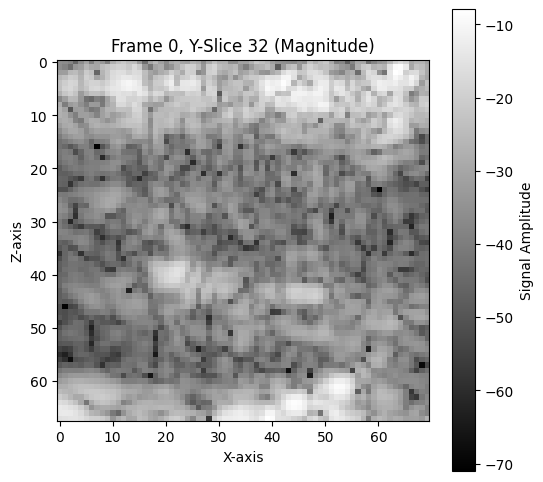

In [4]:
import matplotlib.pyplot as plt
frame0 = IQ[0]
mag = np.abs(frame0)
log_img = 20 * np.log10(mag / mag.max() + 1e-12)
# --- Visualization (Slicing the 3D Volume) ---
y_slice_index = mag.shape[1] // 2 
plt.figure(figsize=(6, 6))
plt.imshow(log_img[:, y_slice_index, :].T, cmap='gray')
plt.title(f"Frame 0, Y-Slice {y_slice_index} (Magnitude)")
plt.colorbar(label='Signal Amplitude')
plt.xlabel("X-axis")
plt.ylabel("Z-axis")
plt.show()

In [34]:
import ipywidgets as widgets
from IPython.display import display

vol = np.abs(IQ[0])

def view_slice(i):
    plt.figure(figsize=(5,5))
    plt.imshow(20*np.log10(vol[:, :, i] + 1e-6), cmap='gray')
    plt.title(f"Slice {i}")
    plt.colorbar(label='Signal Amplitude')
    plt.xlabel("Y-axis")
    plt.ylabel("X-axis")
    plt.show()

slider = widgets.IntSlider(0, 0, vol.shape[2]-1, 1)
widgets.interact(view_slice, i=slider)

interactive(children=(IntSlider(value=0, description='i', max=67), Output()), _dom_classes=('widget-interact',…

<function __main__.view_slice(i)>

In [33]:
!pip install matplotlib

In [15]:
print("Size:", f["PData/Size"][:].ravel())
print("Delta:", f["PData/PDelta"][:].ravel())
print("Origin:", f["PData/Origin"][:].ravel())

Size: [65. 70. 68.]
Delta: [0.76095779 0.76095779 0.5       ]
Origin: [-24.35064935 -26.25304383  19.        ]


NameError: name 'IQ' is not defined

In [7]:
f["#refs#"]

<HDF5 group "/#refs#" (1 members)>

In [1]:
!unzip "IQ_051_100.zip"

Archive:  IQ_051_100.zip
   creating: IQ_051_100/
  inflating: IQ_051_100/IQ051.mat    
  inflating: IQ_051_100/IQ052.mat    
  inflating: IQ_051_100/IQ053.mat    
  inflating: IQ_051_100/IQ054.mat    
  inflating: IQ_051_100/IQ055.mat    
  inflating: IQ_051_100/IQ056.mat    
  inflating: IQ_051_100/IQ057.mat    
  inflating: IQ_051_100/IQ058.mat    
  inflating: IQ_051_100/IQ059.mat    
  inflating: IQ_051_100/IQ060.mat    
  inflating: IQ_051_100/IQ061.mat    
  inflating: IQ_051_100/IQ062.mat    
  inflating: IQ_051_100/IQ063.mat    
  inflating: IQ_051_100/IQ064.mat    
  inflating: IQ_051_100/IQ065.mat    
  inflating: IQ_051_100/IQ066.mat    
  inflating: IQ_051_100/IQ067.mat    
  inflating: IQ_051_100/IQ068.mat    
  inflating: IQ_051_100/IQ069.mat    
  inflating: IQ_051_100/IQ070.mat    
  inflating: IQ_051_100/IQ071.mat    
  inflating: IQ_051_100/IQ072.mat    
  inflating: IQ_051_100/IQ073.mat    
  inflating: IQ_051_100/IQ074.mat    
  inflating: IQ_051_100/IQ075.mat    


main.py  test.ipynb


In [5]:
import os
os.listdir("/teamspace/uploads")

['.lightning_uploads']